<a href="https://colab.research.google.com/github/AlexKazmin/SkillFactory-Projects/blob/main/OD_2_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D1%8D%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BD%D0%BE%D0%B2%D0%BE%D0%B9_%D1%84%D0%B8%D1%87%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ЦЕЛЬ
Оценить эффетивность внедрения новой фичи



# ЗАДАЧИ
1. Посчитать показатели Retention Rate седьмого дня за два периода: до и после внедрения фичи.
2. Посчитать показатели ARPPU за два периода: до и после внедрения фичи.

## Сбор и обработка данных

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)



Для начала определим количество зарегистрировавшихся пользователей в каждый день мая.

Создадим функцию getRegisteredUsersCount(), в которой выполним SQL-запрос.

Подсчитаем количество зарегистрировавшихся пользователей registered_users_count за май 2019 года в разрезе registration_date — дней регистрации.

Конструкция pd.DataFrame(getRegisteredUsersCount()) позволяет выполнить функцию запроса, а затем записать полученные данные в датафрейм.

In [2]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count_may = pd.DataFrame(getRegisteredUsersCount())

In [3]:
registered_users_count_may.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       31 non-null     object
 1   registered_users_count  31 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes


Мы видим, что колонка registration_date имеет тип object. Поэтому преобразуем её в тип datetime:

In [4]:
registered_users_count_may['registration_date'] = pd.to_datetime(registered_users_count_may['registration_date'])

Посмотрим количество пользователей, зарегистрировавшихся в мае:

In [5]:
registered_users_count_may['registered_users_count'].sum()

188943

In [6]:
registered_users_count_may.head()

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


Мы получили количество пользователей, зарегистрировавшихся в мае. Но мы не знаем, сколько из них впоследствии возвращалось в сервис.

Посчитаем количество активных пользователей в разрезе когорт. В качестве когорты будет выступать дата регистрации. Таким образом, мы определим количество активных пользователей по дням в разрезе даты регистрации.

Сперва получим данные об активных пользователях из базы и подсчитаем по дням количество активных пользователей active_users_count с указанием даты регистрации registration_date.

Создадим функцию getActiveUsersCountWithCohorts() и запишем данные, полученные с помощью этой функции, в датафрейм active_users_count_with_cohorts.

In [7]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [8]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       961 non-null    object
 1   registration_date   961 non-null    object
 2   active_users_count  961 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


Колонки с датами также имеют тип object, то есть строковый тип. Преобразуем их в тип datetime.

In [9]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [10]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


Теперь у нас есть две таблицы:

Таблица с количеством пользователей, которые изначально были в когортах, — это датафрейм registered_users_count.

Таблица с количеством активных пользователей по дням в каждой когорте — это датафрейм active_users_count_with_cohorts.

Чтобы рассчитать процент вернувшихся пользователей на определённый день, объединим две таблицы.

In [11]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count_may,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-01,2019-05-01,2590,6516
1,2019-05-02,2019-05-01,2146,6516
2,2019-05-02,2019-05-02,2049,5309
3,2019-05-03,2019-05-01,1637,6516
4,2019-05-03,2019-05-02,1817,5309


Таким образом, для каждой когорты registration_date мы указали количество пользователей, зарегистрировавшихся в этой когорте.

Теперь мы можем рассчитать показатель Retention Rate. Найдём отношение количества активных пользователей active_users_count к количеству зарегистрировавшихся пользователей registered_users_count в этой когорте. Запишем полученное значение в колонку retention_rate:

In [12]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


## СЧИТАЕМ RETENTION RATE ДЛЯ РАЗНЫХ ДНЕЙ

Мы рассчитали Retention Rate для каждого дня.

Основная масса клиентов из числа физических лиц обращается в наш сервис раз в месяц, поэтому рассчитаем Retention Rate на определённый день относительно даты регистрации в сервисе.

Если мы смотрим на когорту пользователей, зарегистрировавшихся 1 мая 2019, и хотим оценить Retention Rate на день активности 3 мая 2019 года, то это будет Retention Rate на второй день (активность на 1 мая считается активностью на нулевой день).

В датафрейме retention_table определяем, какое количество дней прошло с момента регистрации до определённого дня активности. 

In [13]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'].head()

0   0 days
1   1 days
2   0 days
3   2 days
4   1 days
Name: lifetime, dtype: timedelta64[ns]

Но timedelta при вычитании одной даты из другой будет подсчитана в днях. Это видно по типу данных в колонке timedelta64[ns].

Нам нужно получить целое количество дней, поэтому значения в колонке с типом timedelta мы разделим на константу np.timedelta64(1,'D'):

In [14]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int64

Теперь у нас в колонке lifetime содержится целое количество дней, прошедших с регистрации до даты активности.

Следующий наш шаг — сформировать сводную таблицу, которая позволяет для каждой когорты оценить Retention Rate за порядковый день активности.

## Формирование сводной таблицы

Сформируем сводную таблицу retention_pivot:

In [15]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179
2019-05-06,0.368205,0.312260,0.227748,0.191377,0.162809,0.147732,0.137680,0.130274,0.117445,0.105806,...,0.065997,0.062029,0.060045,0.055680,0.053829,0.050919,0.049597,0.048142,0.035048,0.021690
2019-05-07,0.366349,0.326020,0.239393,0.206808,0.172770,0.153251,0.142926,0.137280,0.124859,0.113405,...,0.070657,0.062591,0.063559,0.060816,0.058235,0.057106,0.057590,0.055815,0.041781,0.028392
2019-05-08,0.393985,0.328271,0.245564,0.198195,0.176241,0.156692,0.142707,0.132782,0.121353,0.110977,...,0.066316,0.063910,0.058195,0.056842,0.053534,0.053835,0.052632,0.048872,0.038496,0.026617
2019-05-09,0.377529,0.320909,0.236777,0.205183,0.180866,0.163649,0.147497,0.136138,0.124068,0.113774,...,0.067093,0.066205,0.061945,0.060703,0.058218,0.055201,0.053958,0.054846,0.045971,0.029464


Такую таблицу удобно визуализировать с помощью heatmap в библиотеке seaborn:

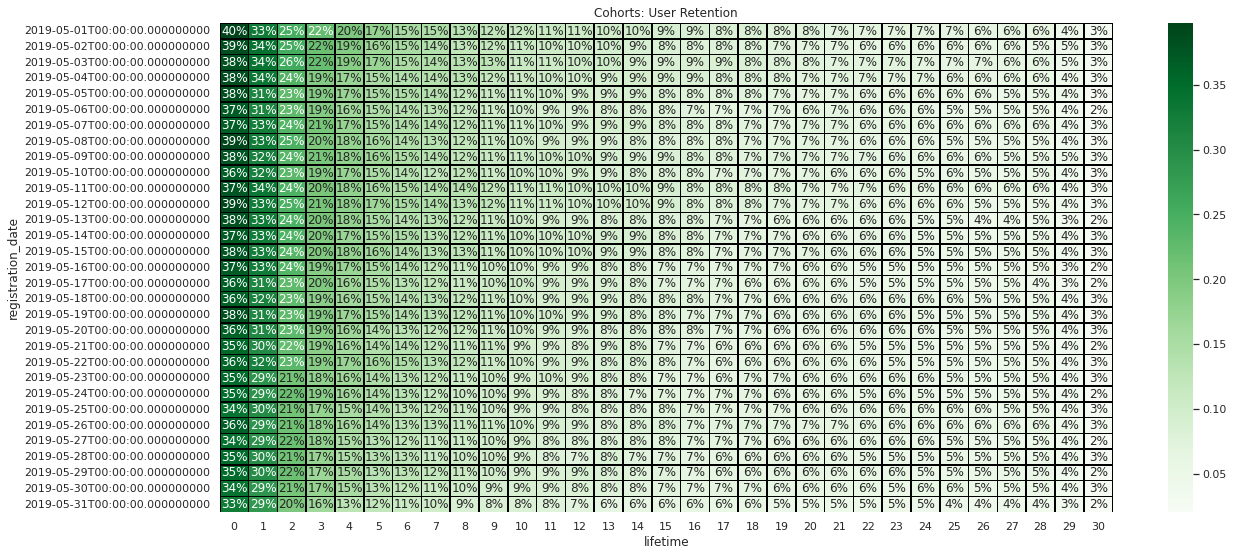

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

С помощью retention_pivot удобно визуализировать изменения Retention Rate по каждой когорте с течением времени. Построим, например, как в зависимости от когорты изменяется Retention Rate на нулевой день.

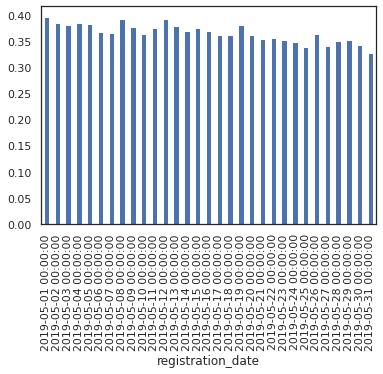

In [17]:
retention_pivot[0].plot.bar()

Retention Rate на нулевой день падает с течением времени: если для когорт в начале мая он составляет около 40%, то для когорт пользователей, зарегистрировавшихся в конце мая, показатель возврата уже меньше 35%.

Оценим изменение Retention Rate когорт на седьмой день.

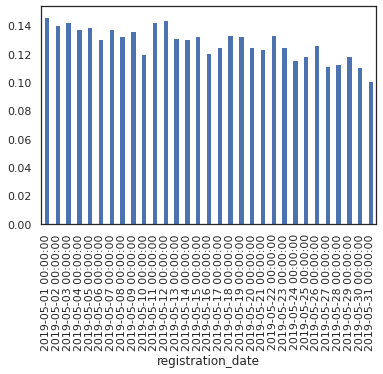

In [18]:
retention_pivot[7].plot.bar()

Визуально падение выглядит ещё более сильным. Проверим, так ли это.

Найдём относительное изменение Retention Rate на седьмой день для когорты 31 мая 2019 года относительно когорты 1 мая 2019 года.

In [19]:
retention_pivot[7]['2019-05-31']/retention_pivot[7]['2019-05-01']

0.6889460885141001

Retention Rate когорты 31 мая 2019 года на седьмой день составляет 69% относительно аналогичного показателя когорты 1 мая 2019 года. Значит, мы можем говорить о том, что Retention Rate с течением времени действительно снижается.

## СЧИТАЕМ ВЫРУЧКУ ПО ДНЯМ

У нас уже есть датафрейм, в котором хранится информация об активных пользователях, — это retention_table.

Чтобы посчитать ARPU, нам не хватает информации о выручке по дням, разбитой на когорты (как мы делали с retention_table).

Напишем SQL-запрос, который позволит получить выручку по дням в разрезе когорт для пользователей, зарегистрировавшихся в мае 2019 года. Этот запрос обернём в функцию getRevenue(), после чего получим данные по запросу и запишем в датафрейм revenue.

In [20]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())

In [21]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      912 non-null    object 
 1   registration_date         912 non-null    object 
 2   users_count_with_revenue  912 non-null    int64  
 3   revenue                   912 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6+ KB


Как это было с предыдущими датафреймами, колонки с датами содержат тип object. Произведём преобразование типов к datetime.



In [22]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

In [23]:
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,1672,2357.590
1,2019-05-02,2019-05-01,1420,514.679
2,2019-05-02,2019-05-02,1367,1629.140
3,2019-05-03,2019-05-01,1048,390.952
4,2019-05-03,2019-05-02,1164,533.608


Посчитаем сумму выручки, которую принесли пользователи, зарегистрировавшиеся в мае.



In [24]:
revenue['revenue'].sum()

121998.29864999998

## СЧИТАЕМ СРЕДНЮЮ ВЫРУЧКУ

Как мы выяснили, пользователи, зарегистрировавшиеся в мае, принесли выручку 121 998 $. А сколько всего было таких пользователей?

Их количество нам уже известно. Подсчитать его можно на основе датафрейма registered_users_count.

In [26]:
registered_users_count_may['registered_users_count'].sum()

188943

Зная два числа — выручку и количество зарегистрировавшихся пользователей — мы можем рассчитать среднюю выручку за месяц с пользователей, зарегистрировавшихся в мае.

In [28]:
revenue['revenue'].sum()/registered_users_count_may['registered_users_count'].sum()

0.6456883750654958

## ОБЪЕДИНЯЕМ ДАТАФРЕЙМЫ

Следующий шаг — объединение данных из датафрейма revenue с данными из датафрейма retention_table. Но прежде в датафрейме revenue следует изменить название колонки date на activity_date. Делаем это с тем, чтобы в дальнейшем объединять датафреймы по одинаковому названию колонок.

In [29]:
revenue = revenue.rename(columns={'date':'activity_date'})

После переименования можно объединить датафреймы в новый датафрейм retention_table_with_revenue.

In [30]:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

Посмотрим на получившийся объединённый датафрейм.

In [31]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672.0,2357.590
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420.0,514.679
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367.0,1629.140
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048.0,390.952
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164.0,533.608


In [32]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             961 non-null    datetime64[ns]
 1   registration_date         961 non-null    datetime64[ns]
 2   active_users_count        961 non-null    int64         
 3   registered_users_count    961 non-null    int64         
 4   retention_rate            961 non-null    float64       
 5   lifetime                  961 non-null    int64         
 6   users_count_with_revenue  912 non-null    float64       
 7   revenue                   912 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(3)
memory usage: 67.6 KB


После объединения видим, что есть пропущенные значения. Это говорит о том, что не во все дни была выручка с пользователей.

Произведём замену пропущенных значений на 0 с помощью функции fillna().

In [33]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

Преобразуем тип в колонке users_count_with_revenue в целочисленный.

In [34]:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

Теперь всё готово для того, чтобы посчитать показатель ARPPU.

## СЧИТАЕМ ARPPU

In [35]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue']/retention_table_with_revenue['users_count_with_revenue']
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.590,1.410042
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679,0.362450
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140,1.191763
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048,390.952,0.373046
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164,533.608,0.458426


## Retention Rate седьмого дня за два периода: до и после внедрения фичи.

Фича была поставлена 1 июня. Данные за май мы уже отобрали, выгружаем данные о зарегистрировавшихся пользователей registered_users_count_june за июнь 2019 года в разрезе registration_date — дней регистрации.

In [36]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count_june = pd.DataFrame(getRegisteredUsersCount())

In [37]:
registered_users_count_june.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       30 non-null     object
 1   registered_users_count  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


In [38]:
#Переводим столбец дат в соответствующий тип
registered_users_count_june['registration_date'] = pd.to_datetime(registered_users_count_june['registration_date'])

Подсчитаем по дням количество активных пользователей active_users_count_may в мае с указанием даты регистрации registration_date.

In [39]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts_may = pd.DataFrame(getActiveUsersCountWithCohorts())

Подсчитаем по дням количество активных пользователей active_users_count_june в июне с указанием даты регистрации registration_date.

In [40]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts_june = pd.DataFrame(getActiveUsersCountWithCohorts())

In [41]:
active_users_count_with_cohorts_june.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       930 non-null    object
 1   registration_date   930 non-null    object
 2   active_users_count  930 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [42]:
#Переводим столбцы дат в соответствующий тип
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts_may[col] = pd.to_datetime(active_users_count_with_cohorts_may[col])
    
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts_june[col] = pd.to_datetime(active_users_count_with_cohorts_june[col])

In [43]:
#Объединяем таблицы по колонке registration_date
retention_table_may = active_users_count_with_cohorts_may.merge(registered_users_count_may,on=['registration_date'],how='left')
retention_table_june = active_users_count_with_cohorts_june.merge(registered_users_count_june,on=['registration_date'],how='left')

In [44]:
#Какое количество дней прошло с момента регистрации до определённого дня активности
retention_table_may['lifetime'] = retention_table_may['activity_date'] - retention_table_may['registration_date']
#Нужно получить целое количество дней, поэтому значения в колонке с типом timedelta мы разделим на константу np.timedelta64(1,'D'):
retention_table_may['lifetime'] = retention_table_may['lifetime']/np.timedelta64(1,'D')
retention_table_may['lifetime'] = retention_table_may['lifetime'].astype(int) # Приведем тип к целому числу

In [45]:
#Retention Rate на седьмой день в мае
retention_7_table_may = retention_table_may[retention_table_may['lifetime'] == 7]
retention_7_may = retention_7_table_may.active_users_count.sum()/retention_7_table_may.registered_users_count.sum()
retention_7_may

0.12933000957960866

In [46]:
#Какое количество дней прошло с момента регистрации до определённого дня активности
retention_table_june['lifetime'] = retention_table_june['activity_date'] - retention_table_june['registration_date']
#Нужно получить целое количество дней, поэтому значения в колонке с типом timedelta мы разделим на константу np.timedelta64(1,'D'):
retention_table_june['lifetime'] = retention_table_june['lifetime']/np.timedelta64(1,'D')
retention_table_june['lifetime'] = retention_table_june['lifetime'].astype(int) # Приведем тип к целому числу

In [47]:
#Retention Rate на седьмой день в июне
retention_7_table_june = retention_table_june[retention_table_june['lifetime'] == 7]
retention_7_june = retention_7_table_june.active_users_count.sum()/retention_7_table_june.registered_users_count.sum()
retention_7_june

0.12560867530346634

Возвращаемость и удержание пользователей на 7 день стала чуть меньше.

## ARPPU за два периода: до и после внедрения фичи
Напишем SQL-запрос, который позволит получить выручку по дням в разрезе когорт для пользователей, зарегистрировавшихся в мае 2019 года.

In [48]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue_may = pd.DataFrame(getRevenue())

Напишем SQL-запрос, который позволит получить выручку по дням в разрезе когорт для пользователей, зарегистрировавшихся в июне 2019 года.

In [49]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue_june = pd.DataFrame(getRevenue())

In [50]:
#Переводим столбец дат в соответствующий тип
for col in ['date','registration_date']:
    revenue_may[col] = pd.to_datetime(revenue_may[col])
    
for col in ['date','registration_date']:
    revenue_june[col] = pd.to_datetime(revenue_june[col])

In [51]:
#Переименуем столбцы дат перед объединением
revenue_may = revenue_may.rename(columns={'date':'activity_date'})
revenue_june = revenue_june.rename(columns={'date':'activity_date'})

In [52]:
#Объединяем таблицы
retention_table_with_revenue_may = retention_table_may.merge(revenue_may,on=['registration_date','activity_date'],how='left')
retention_table_with_revenue_june = retention_table_june.merge(revenue_june,on=['registration_date','activity_date'],how='left')

In [53]:
retention_table_with_revenue_may.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             961 non-null    datetime64[ns]
 1   registration_date         961 non-null    datetime64[ns]
 2   active_users_count        961 non-null    int64         
 3   registered_users_count    961 non-null    int64         
 4   lifetime                  961 non-null    int64         
 5   users_count_with_revenue  912 non-null    float64       
 6   revenue                   912 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 60.1 KB


После объединения видим, что есть пропущенные значения. Это говорит о том, что не во все дни была выручка с пользователей.

Произведём замену пропущенных значений на 0 с помощью функции fillna().

In [54]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue_may[col] = retention_table_with_revenue_may[col].fillna(0)
    
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue_june[col] = retention_table_with_revenue_june[col].fillna(0)

In [55]:
#Преобразуемы столбцы с количеством платящих пользователей в целочисленный формат
retention_table_with_revenue_may['users_count_with_revenue'] = retention_table_with_revenue_may['users_count_with_revenue'].astype(int)
retention_table_with_revenue_june['users_count_with_revenue'] = retention_table_with_revenue_june['users_count_with_revenue'].astype(int)

In [56]:
#ARPPU в мае
arppu_may = retention_table_with_revenue_may['revenue'].sum()/retention_table_with_revenue_may['users_count_with_revenue'].sum()
arppu_may

0.306124581017502

In [57]:
#ARPPU в июне
arppu_june = retention_table_with_revenue_june['revenue'].sum()/retention_table_with_revenue_june['users_count_with_revenue'].sum()
arppu_june

0.3931939497934996

# Выводы

In [58]:
print('Retention Rate седьмого дня до внедрения фичи: {:.2%}'.format(retention_7_may))
print('Retention Rate седьмого дня после внедрения фичи: {:.2%}'.format(retention_7_june))
print('ARPPU до внедрения фичи: {:.2} у.е.'.format(arppu_may))
print('ARPPU после внедрения фичи: {:.2} у.е.'.format(arppu_june))

Retention Rate седьмого дня до внедрения фичи: 12.93%
Retention Rate седьмого дня после внедрения фичи: 12.56%
ARPPU до внедрения фичи: 0.31 у.е.
ARPPU после внедрения фичи: 0.39 у.е.



* Retention 7 дня остался примерно на прежнем уровне
* Тем не менее ARPPU в июне вырос на 30%

Возможно, на ARPPU могли повлиять и другие факторы. Чтобы убедиться в этом, необходимо было бы провести раскатку функционала на часть пользователей и/или провести анализ с учетом фактора использования конкретно нашей фичи, однако таких данных, у нас нет. Здесь явно имеет смысл настроить сбор таких данных на будущее, но на текущий момент и в текущих условиях можно сказать, что наша фича оказалась вполне эффективна. Во всяком случае, ARPPU она не обрушила, а значит можно оставлять ее на проде.  